In [12]:
from dataclasses import is_dataclass, asdict
from collections.abc import Mapping, Iterable
from pprint import pprint

_PRIMITIVES = (str, bytes, int, float, bool, type(None))

def _shorten_id(s: str) -> str:
    if not isinstance(s, str):
        return s
    return "..." + s[-4:] if len(s) >= 4 else "..." + s

def _to_plain(x, _active=None, *, full_ids=False, parent_type=None):
    # Primitives: never tracked for cycles
    if isinstance(x, _PRIMITIVES):
        return x

    if _active is None:
        _active = set()

    oid = id(x)
    if oid in _active:
        return "<…cycle…>"
    _active.add(oid)
    try:
        # Dataclasses
        if is_dataclass(x):
            data = asdict(x)
            return {type(x).__name__: _to_plain(data, _active, full_ids=full_ids, parent_type=type(x).__name__)}

        # Namedtuple / has _asdict
        if hasattr(x, "_asdict"):
            try:
                data = x._asdict()
                return {type(x).__name__: _to_plain(data, _active, full_ids=full_ids, parent_type=type(x).__name__)}
            except Exception:
                pass

        # Mappings
        if isinstance(x, Mapping):
            out = {}
            for k, v in x.items():
                key_str = str(k)
                if not full_ids:
                    if key_str == "checkpoint_id" and isinstance(v, str):
                        v = _shorten_id(v)
                    elif key_str == "id" and parent_type == "PregelTask" and isinstance(v, str):
                        v = _shorten_id(v)
                out[key_str] = _to_plain(v, _active, full_ids=full_ids, parent_type=parent_type)
            return out

        # Iterables (lists/tuples/sets, etc.)
        if isinstance(x, Iterable):
            return [_to_plain(i, _active, full_ids=full_ids, parent_type=parent_type) for i in x]

        # Generic objects
        if hasattr(x, "__dict__"):
            return {
                type(x).__name__: {
                    k: _to_plain(v, _active, full_ids=full_ids, parent_type=type(x).__name__)
                    for k, v in x.__dict__.items()
                    if not k.startswith("__") and not callable(v)
                }
            }

        # Fallback
        return repr(x)
    finally:
        _active.remove(oid)

def pretty_print_snapshot(snapshot, *, sort_dicts=True, width=100, full_ids=False):
    pprint(_to_plain(snapshot, full_ids=full_ids), sort_dicts=sort_dicts, width=width)


In [2]:
# Helper to briefly write ckpoint information
def shst(config, verbose=False):
    #config = {"configurable": {"thread_id": "1"}}
    sh = list(graph.get_state_history(config))
    lsh = len(sh)
    for i, s in enumerate(sh):
        #print(s)
        print(f'{-(lsh-i)}:{i}:{s.metadata.get("step")}', s.config["configurable"]["checkpoint_id"][-4:],
              s.next, s.values)
        if verbose:
            for i, t in enumerate(s.tasks or ()):
                print("        ",f"task[{i}] name={getattr(t, 'name', None)} result={getattr(t, 'result', None)}")
        #print(s.config["configurable"]["checkpoint_id"])

def sh_all_st(config):
    sh = list(graph.get_state_history(config))
    lsh = len(sh)
    for i, s in enumerate(sh):
        print(f'{-(lsh-i)}:{i}:{s.metadata.get("step")}')
        print(s)


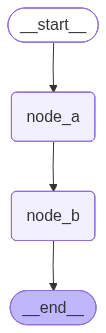

Node a receiving state {'foo': 'begin', 'bar': []}
Node b receiving state {'foo': 'a', 'bar': ['a']}


{'foo': 'b', 'bar': ['a', 'b']}

In [3]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig
from typing import Annotated
from typing_extensions import TypedDict
from operator import add
from IPython.display import Image, display

class State(TypedDict):
    foo: str 
    bar: Annotated[list[str], add]

def node_a(state: State):
    print(f"Node a receiving state {state}")
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    print(f"Node b receiving state {state}")
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
display(Image(graph.get_graph().draw_mermaid_png()))
config: RunnableConfig = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": "begin"}, config)

In [4]:
shst(config)

-4:0:2 16f5 () {'foo': 'b', 'bar': ['a', 'b']}
-3:1:1 479a ('node_b',) {'foo': 'a', 'bar': ['a']}
-2:2:0 fda5 ('node_a',) {'foo': 'begin', 'bar': []}
-1:3:-1 a754 ('__start__',) {'bar': []}


#### Start Clean

In [5]:
## start clean
import uuid
thread_id = uuid.uuid4().hex[-4:] # so we start fresh each time we run this

config: RunnableConfig = {"configurable": {"thread_id": thread_id}}
graph.invoke({"foo": "begin"}, config)

Node a receiving state {'foo': 'begin', 'bar': []}
Node b receiving state {'foo': 'a', 'bar': ['a']}


{'foo': 'b', 'bar': ['a', 'b']}

In [6]:
shst(config, verbose=True)

-4:0:2 cc4e () {'foo': 'b', 'bar': ['a', 'b']}
-3:1:1 fb0e ('node_b',) {'foo': 'a', 'bar': ['a']}
         task[0] name=node_b result={'foo': 'b', 'bar': ['b']}
-2:2:0 9d48 ('node_a',) {'foo': 'begin', 'bar': []}
         task[0] name=node_a result={'foo': 'a', 'bar': ['a']}
-1:3:-1 c10b ('__start__',) {'bar': []}
         task[0] name=__start__ result={'foo': 'begin'}


Lets update state using [-2] as our starting point.

In [7]:
sh = list(graph.get_state_history(config))
u_config = sh[-2].config
graph.get_state(u_config)

StateSnapshot(values={'foo': 'begin', 'bar': []}, next=('node_a',), config={'configurable': {'thread_id': '6a2c', 'checkpoint_ns': '', 'checkpoint_id': '1f0b01e1-c7c9-6dd6-8000-c0151cc79d48'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-23T14:39:42.192167+00:00', parent_config={'configurable': {'thread_id': '6a2c', 'checkpoint_ns': '', 'checkpoint_id': '1f0b01e1-c7c5-69ca-bfff-b030861bc10b'}}, tasks=(PregelTask(id='12ea5b4f-997b-bf1f-321d-c632b357bf20', name='node_a', path=('__pregel_pull', 'node_a'), error=None, interrupts=(), state=None, result={'foo': 'a', 'bar': ['a']}),), interrupts=())

In [8]:
new_config = graph.update_state(u_config, {"foo": 42, "bar": [f"oque"]}, as_node='__start__')
graph.get_state(new_config)


StateSnapshot(values={'foo': 42, 'bar': ['a', 'oque']}, next=('node_a',), config={'configurable': {'thread_id': '6a2c', 'checkpoint_ns': '', 'checkpoint_id': '1f0b01e1-e25d-61e8-8001-7cc2b57582e1'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-10-23T14:39:44.978775+00:00', parent_config={'configurable': {'thread_id': '6a2c', 'checkpoint_ns': '', 'checkpoint_id': '1f0b01e1-c7c9-6dd6-8000-c0151cc79d48'}}, tasks=(PregelTask(id='7905c6b9-2045-0146-9393-81b46a676b77', name='node_a', path=('__pregel_pull', 'node_a'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [9]:
shst(config,verbose=True)

-5:0:1 82e1 ('node_a',) {'foo': 42, 'bar': ['a', 'oque']}
         task[0] name=node_a result=None
-4:1:2 cc4e () {'foo': 'b', 'bar': ['a', 'b']}
-3:2:1 fb0e ('node_b',) {'foo': 'a', 'bar': ['a']}
         task[0] name=node_b result={'foo': 'b', 'bar': ['b']}
-2:3:0 9d48 ('node_a',) {'foo': 'begin', 'bar': []}
         task[0] name=node_a result={'foo': 'a', 'bar': ['a']}
-1:4:-1 c10b ('__start__',) {'bar': []}
         task[0] name=__start__ result={'foo': 'begin'}


The state prior to node_a - where node_a is the next value, is at -2.  
The state at that point is ` {'foo': 'begin', 'bar': []}`  
We updated that with update_state with `{"foo": 42, "bar": [f"oque"]}`.  
The final state however, is `{'foo': 42, 'bar': ['a', 'oque']}`  with an extra 'a' in 'bar'.  
The `result={'foo': 'a', 'bar': ['a']}` appears to be included in the update.


This result is similar to the example of time travel in LangGraph module 3 where an extra AI message is appearing (That example is considerably more complex).

In [13]:
sh = list(graph.get_state_history(config))
pretty_print_snapshot(sh[-2])

{'StateSnapshot': {'config': {'configurable': {'checkpoint_id': '...9d48',
                                               'checkpoint_ns': '',
                                               'thread_id': '6a2c'}},
                   'created_at': '2025-10-23T14:39:42.192167+00:00',
                   'interrupts': [],
                   'metadata': {'parents': {}, 'source': 'loop', 'step': 0},
                   'next': ['node_a'],
                   'parent_config': {'configurable': {'checkpoint_id': '...c10b',
                                                      'checkpoint_ns': '',
                                                      'thread_id': '6a2c'}},
                   'tasks': [{'PregelTask': {'error': None,
                                             'id': '...bf20',
                                             'interrupts': [],
                                             'name': 'node_a',
                                             'path': ['__pregel_pull', 'node_a'],
 